In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:

def m2_load_token_and_label():

  test = pd.read_pickle("token_test_data_ver2.pkl")
  train = pd.read_pickle("token_train_data_ver2.pkl")

  training_sentences, training_labels = train['token'], train['label']
  testing_sentences, testing_labels = test['token'], test['label']

  return training_sentences, training_labels, testing_sentences, testing_labels

def m2_tokenizer():

  vocab_size = 20000
  embedding_dim = 200
  max_length = 30
  truct_type = 'post'
  padding_type = 'post'
  oov_tok = '<OOV>'

  training_sentences, training_labels, testing_sentences, testing_labels = m2_load_token_and_label()

  tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
  tokenizer.fit_on_texts(training_sentences)
  word_idx = tokenizer.index_word


  # Sequence/ Padding
  training_sequences  = tokenizer.texts_to_sequences(training_sentences)
  training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                  padding=padding_type, truncating=truct_type)


  testing_sequences  = tokenizer.texts_to_sequences(testing_sentences)
  testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                                  padding=padding_type, truncating=truct_type)
  # word2vec weight 
  vocab_size = len(word_idx) + 1
  embedding_dim = 200

  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  ko_model= Word2Vec.load('word2vec_movie.model')

  for word, idx in tokenizer.word_index.items():
      embedding_vector = ko_model[word] if word in ko_model else None
      if embedding_vector is not None:
          embedding_matrix[idx] = embedding_vector

  return training_padded, testing_padded, training_labels,testing_labels,embedding_matrix, vocab_size

In [10]:
def plot_graphs(history, string, name='model'):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.title(name)
    plt.legend([string, 'val_' + string])

    fig = plt.gcf()
    ##저장될 폴더생성
    result_dir = './result_file'
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    fig.savefig(result_dir+'/{}.png'.format(name), dpi = fig.dpi)
    print('<{}.png> result_file폴더에 결과 그래프 저장 완료'.format(name))
    plt.show()

In [11]:
def m2_model():

  embedding_dim = 200
  filter_sizes = (3, 4, 5)
  num_filters = 100
  dropout = 0.5
  hidden_dims = 100
  max_length = 30

  conv_blocks =[]
  input_shape = (30)
  model_input = tf.keras.layers.Input(shape=input_shape)
  z = model_input

  training_padded, testing_padded, training_labels,testing_labels,embedding_matrix, vocab_size = m2_tokenizer()
  embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,
                                          weights = [embedding_matrix], trainable = False)(z)
                                          
  for sz in filter_sizes:
      

      conv = tf.keras.layers.Conv1D(filters=num_filters,
                          kernel_size=sz,
                          padding="valid",
                          activation="relu",
                          strides=1)(embedding)
      conv = tf.keras.layers.GlobalAveragePooling1D()(conv)
      conv = tf.keras.layers.Flatten()(conv)
      conv_blocks.append(conv)
  z = tf.keras.layers.Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

  z = tf.keras.layers.Dense(hidden_dims, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.003), bias_regularizer=tf.keras.regularizers.l2(0.003))(z)
  z = tf.keras.layers.Dropout(dropout)(z)
  model_output = tf.keras.layers.Dense(1, activation="sigmoid")(z)
  model = tf.keras.Model(model_input, model_output)

  batch_size = 50
  num_epochs = 10
  min_word_count = 1
  context = 10

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  checkpoint_dir = './ckpt2'
  if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)
  callbacks = [
      keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=0),   
      keras.callbacks.ModelCheckpoint(
          filepath=checkpoint_dir + '/ckpt2-loss={loss:.3f}')
      ]

  history = model.fit(training_padded, training_labels, epochs=10, callbacks=callbacks, batch_size = batch_size, validation_data=(testing_padded, testing_labels))
  accuracy_graph = plot_graphs(history, 'accuracy',name='model2_accuracy')
  loss_graph= plot_graphs(history, 'loss',name='model2_loss')  

  return model, history, accuracy_graph,loss_graph

C:\Users\leeso\anaconda\envs\crawl\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\leeso\anaconda\envs\crawl\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Epoch 1/10
2924/2924 [==============================] - 144s 49ms/step - loss: 0.4381 - accuracy: 0.8142 - val_loss: 0.3981 - val_accuracy: 0.8258
Epoch 2/10
2924/2924 [==============================] - 149s 51ms/step - loss: 0.3947 - accuracy: 0.8283 - val_loss: 0.3892 - val_accuracy: 0.8295
Epoch 3/10
2924/2924 [==============================] - 166s 57ms/step - loss: 0.3828 - accuracy: 0.8368 - val_loss: 0.3793 - val_accuracy: 0.8360
Epoch 4/10
2924/2924 [==============================] - 148s 51ms/step - loss: 0.3726 - accuracy: 0.8420 - val_loss: 0.3761 - val_accuracy: 0.8400
Epoch 5/10
2924/2924 [==============================] - 148s 51ms/step - loss: 0.3646 - accuracy: 0.8463 - val_loss: 0.3804 - val_accuracy: 0.8391
<model2_accuracy.png> result_file폴더에 결과 그래프 저장 완료


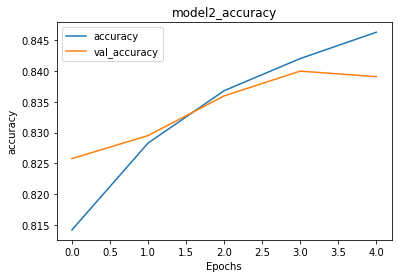

<model2_loss.png> result_file폴더에 결과 그래프 저장 완료


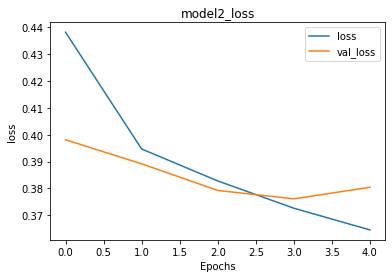

(<tensorflow.python.keras.engine.functional.Functional at 0x221e923fa90>,
 None,
 None)

In [12]:
m2_model()